In [3]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
import os
import pickle
import operator
from collections import defaultdict
import tqdm
import tskit
import numpy as np
import pyslim
import scipy.stats as stats
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects



from bprime.tree_utils import load_recrates, load_neutregions
from bprime.models import BGSModel 
from bprime.utils import load_bed_annotation, load_seqlens, RecMap, midpoint, arg_nearest
from bprime.utils import read_bkgd

In [5]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

In [6]:
force = False

### bgspy B maps

In [7]:
annot = load_bed_annotation(f"../data/annotation/conserved_by_chrom/chr10.bed")
seqlens = load_seqlens("../data/annotation/hg38_seqlens.tsv")
recmap = RecMap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt", seqlens=seqlens, conversion_factor=1e-8)

m = BGSModel(recmap, annot,
             seqlens={'chr10': seqlens['chr10']}, 
             w_grid=np.array([1e-7, 5e-7, 1e-8, 1e-9]),
             t_grid=np.array([0.1, 0.01, 0.001, 0.0001]))

pkl_b_file = '../data/bmaps/bgspy/B_chr10.pkl'


if force or not os.path.exists(pkl_b_file):
    m.calc_B(step=1_000, ncores=70, nchunks=70)
    m.save_B(pkl_b_file)   
else:
    m.load_B(pkl_b_file)

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.


### `calc_bkgd` maps

In [8]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd_file = os.path.join(bkgd_dir, "calc_bkgd_mu1e-8.pkl")

if force or not os.path.exists(cached_bkgd_file):
    bkgd_runs = [os.path.join(bkgd_dir, f) for f in os.listdir(bkgd_dir) if f.startswith('calc_bkgd_s')]

    def load_bkgd(run):
        files = os.listdir(run)
        bkgd = dict()
        for file in files:
            chrom = file.replace('.bkgd', '')
            try:
                bkgd[chrom] = read_bkgd(os.path.join(run, file))
            except ValueError:
                continue
                raise ValueError(f"parsing error at {run}/{file}")
        return bkgd

    bkgd = dict()
    for run in bkgd_runs:
        s = os.path.basename(run).replace('calc_bkgd_s', '')
        bkgd[float(s)] = load_bkgd(run)

    with open(cached_bkgd_file, 'wb') as f:
        pickle.dump(bkgd, f)
else:
    with open(cached_bkgd_file, 'rb') as f:
        bkgd = pickle.load(f)

### Simulation Results

In [9]:
DATADIR = '../data/slim_sims/bgsmap/'
tree_files = [os.path.join(DATADIR, f) for f in os.listdir(DATADIR) if f.endswith('.tree')]

In [10]:
len(tree_files)

500

In [11]:
def get_b(file, params, width=1000, recrate=1e-8, seed=None):
    "Recapitate trees and calc B"
    ts = pyslim.load(file)
    md = ts.metadata['SLiM']['user_metadata']
    region_length = md['region_length'][0]
    N = md['N'][0]
    #recmap = load_recrates('../data/annotation/rec_100kb_chr10.bed', ts.sequence_length)
    rts = pyslim.recapitate(ts, recombination_rate=recrate, sequence_length=ts.sequence_length,
                            ancestral_Ne=N, random_seed=seed)
    length = int(ts.sequence_length)
    neut_positions = np.linspace(0, length, length // width).astype(int)
    params = {k: md[k][0] for k in params}
    return tuple(params.items()), neut_positions, rts.diversity(mode='branch', windows=neut_positions) / (4*N)



In [12]:
cached_bgsmap_file = '../data/bmaps/bgsmap_sims.pkl'

if force or not os.path.exists(cached_bkgd_file):
    sims = defaultdict(list)

    for file in tqdm.tqdm(tree_files):
        params, pos, b = get_b(file, ('s', 'mu'))
        sims[params].append((pos, b))

    for key, res in sims.items():
        pos = list(map(operator.itemgetter(0), res))
        b = list(map(operator.itemgetter(1), res))
        sims[key] = np.stack(pos)[0, :], np.stack(b).T
    with open(cached_bgsmap_file, 'wb') as f:
        pickle.dump(sims, f)
else:
    with open(cached_bgsmap_file, 'rb') as f:
        sims = pickle.load(f)    

In [13]:
m.recmap.rates['chr10']

RecPair(end=array([        0,     72765,     94172, ..., 135499163, 135499327,
       135503693]), rate=array([         nan, 1.244590e-09, 1.603590e-09, ..., 5.906078e-08,
       3.358621e-08, 0.000000e+00]))

In [15]:
i = np.zeros(seqlens['chr10'])
for row in m.segments.ranges:
    i[slice(*row)] = 1

covered_bases = np.where(i)[0]
wins = np.linspace(0, seqlens['chr10'], seqlens['chr10'] // 100_000).astype(int)
coverage = stats.binned_statistic(covered_bases, np.full(len(covered_bases), 1), statistic=np.sum, bins=wins)

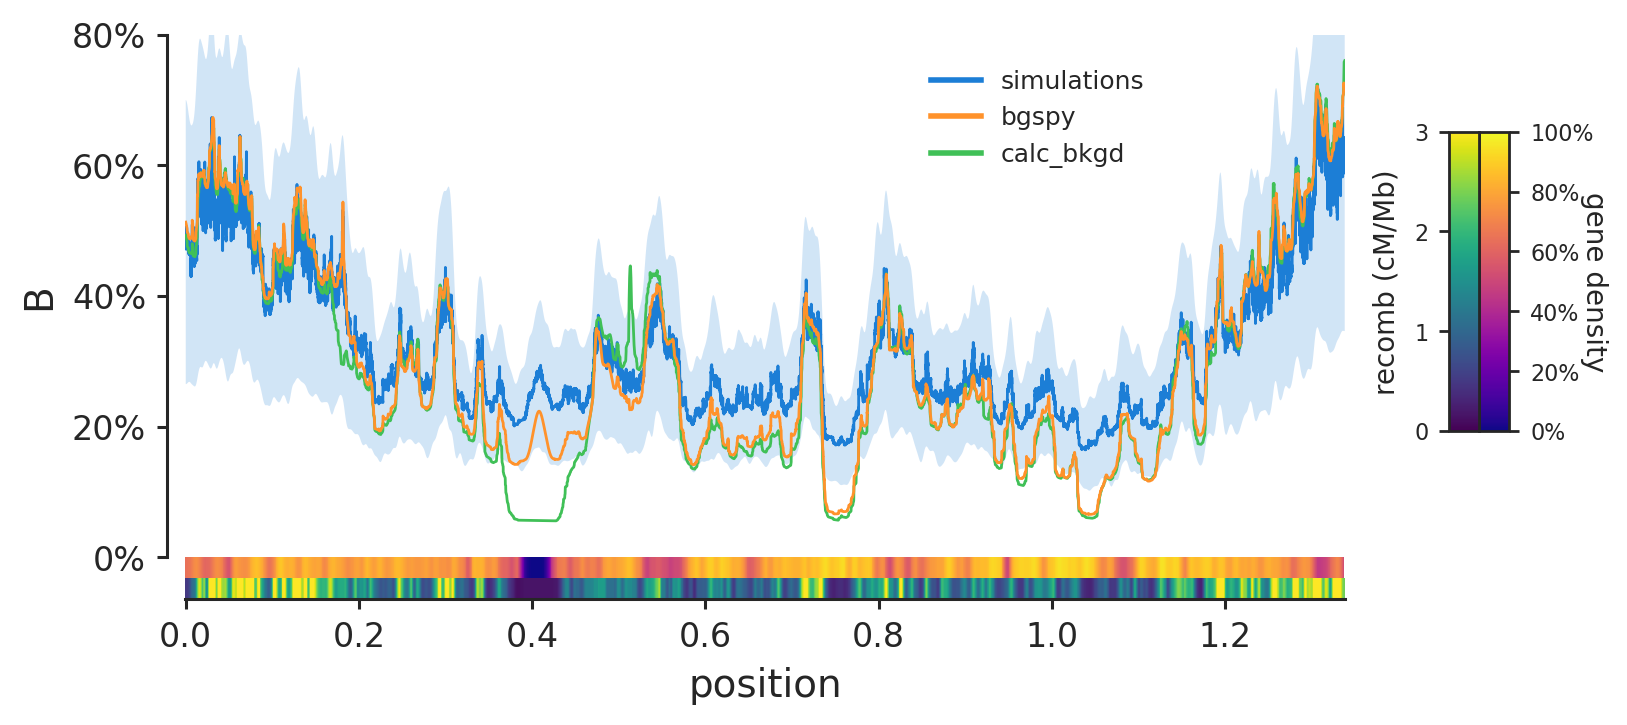

In [31]:
s, mu = 0.02, 1e-8
pos_all, b_all = sims[(('s', s), ('mu', mu))]

bvar = b_all.var(axis=1)
bmean = b_all.mean(axis=1)

max_pos = np.max(m.BScores.pos['chr10'])

pos, bmean, bvar = pos_all[pos_all < max_pos], bmean[midpoint(pos_all) < max_pos], bvar[midpoint(pos_all) < max_pos], 

## main plot
gridkw =  {"height_ratios": [5, 0.2, 0.2], "hspace": 0}
fig, (ax, gene_ax, rec_ax) = plt.subplots(ncols=1, nrows=3, gridspec_kw=gridkw, sharex=True)
fig.set_size_inches(*fig_sizes['two', 'two'])
lw = 1
line = ax.plot(midpoint(pos), bmean, label="simulations", linewidth=lw)
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
line = ax.plot(m.BScores.pos['chr10'], np.exp(bgspy_b), label="bgspy", linewidth=lw, zorder=5)
line = ax.plot(bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1], label="calc_bkgd", linewidth=lw)



lower, upper = bmean + np.sqrt(bvar), bmean - np.sqrt(bvar)
lower2, upper2 = bmean + 2*np.sqrt(bvar), bmean - 2*np.sqrt(bvar)

smooth_lower = gaussian_filter1d(lower, 2e2)
smooth_upper = gaussian_filter1d(upper, 2e2)
#smooth_lower2 = gaussian_filter1d(lower2, 2e2)
#smooth_upper2 = gaussian_filter1d(upper2, 2e2)
ribbon = ax.fill_between(midpoint(pos), smooth_lower, smooth_upper, interpolate=True, alpha=0.2)
#ax.fill_between(midpoint(pos), smooth_lower2, smooth_upper2, interpolate=True, alpha=0.05, facecolor=ribbon.get_facecolor())


leg = ax.legend(loc=(0.6, 0.65), fontsize=9)
for lh in leg.legendHandles:
    lh.set_linewidth(2)

ax.set_xticklabels([])
ax.tick_params(bottom=False)  
ax.set_ylabel('B')
ax.set_ylim(0, 0.8)
ax.yaxis.set_major_formatter(lambda x, pos: f"{int(np.round(100*x))}%")
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_position(('outward', 6.6))
#ax.set_xlim(0, 1.4e8)
#ax.set_xlim(0, max_pos)

n = 10
bar_height = 1
axis_pad = bar_height
ends, rates = m.recmap.rates['chr10']
ends, rates = ends[ends < max_pos], rates[ends < max_pos]
rates[0] = 0
rate_min = 0 # np.quantile(rates, 0.1)
rate_max = 3e-8 #np.quantile(rates, 0.9)
norm = plt.Normalize(rate_min, rate_max)
smooth_rates = gaussian_filter1d(rates, 300)
rec_cbar = rec_ax.pcolormesh(ends, np.arange(n), np.repeat(smooth_rates[:, None], n, axis=1).T, norm=norm)
rec_ax.set_yticks([])
rec_ax.set_xticks(np.arange(0, 1.4e8+1, 20_000_000))
rec_ax.set_xticklabels(np.arange(0, 1.4e8+1, 20_000_000)/1e8)
rec_ax.set_xlabel('position')
rec_ax.tick_params(left=False) 
rec_ax.spines['left'].set_visible(False)

ends, density = coverage.bin_edges, 100*coverage.statistic/(coverage.bin_edges[1:] - coverage.bin_edges[:-1])
norm = plt.Normalize(density.min(), density.max())
smooth_rates = gaussian_filter1d(density, 3)
gene_cbar = gene_ax.pcolormesh(ends[:-1], np.arange(n), np.repeat(smooth_rates[:, None], n, axis=1).T, norm=norm, cmap='plasma')
gene_ax.axis('off')
offset = 0.04
cax2 = fig.add_axes([offset+0.95, 0.35, 0.02, 0.4])
cax1 = fig.add_axes([offset+0.93, 0.35, 0.02, 0.4])
cbar1 = fig.colorbar(rec_cbar, cax=cax1)
cbar2 = fig.colorbar(gene_cbar, cax=cax2)
cax1.yaxis.set_ticks_position('left')
cax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
cax1.set_yticks(np.array([0, 1e-8, 2e-8, 3e-8]))
cax1.set_yticklabels(np.array([0, 1, 2, 3]))
cax1.yaxis.set_label_position('left')
cax1.set_ylabel('recomb (cM/Mb)', fontsize=10)
#cax1.yaxis.set_label_position('left')
cax2.set_ylabel('gene density', fontsize=10, rotation=-90)
cax1.tick_params(labelsize=8)
cax2.tick_params(labelsize=8)
cbar1.outline.set_linewidth(1)
#cbar1.outline.set_visible(False)
#cbar2.outline.set_visible(False)
cbar2.outline.set_linewidth(1) 
cax1.yaxis.set_tick_params(width=1)
cax2.yaxis.set_tick_params(width=1)

In [22]:
ribbon.get_facecolor()

array([[0.10980392, 0.49411765, 0.83921569, 0.16      ]])

Bias by recombination?

In [546]:
np.repeat(rates[:, None], 100, axis=1).shape

(179159, 100)

In [493]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [387]:
binterpols = m.BScores_interpolater(0)

<Figure size 1600x800 with 0 Axes>

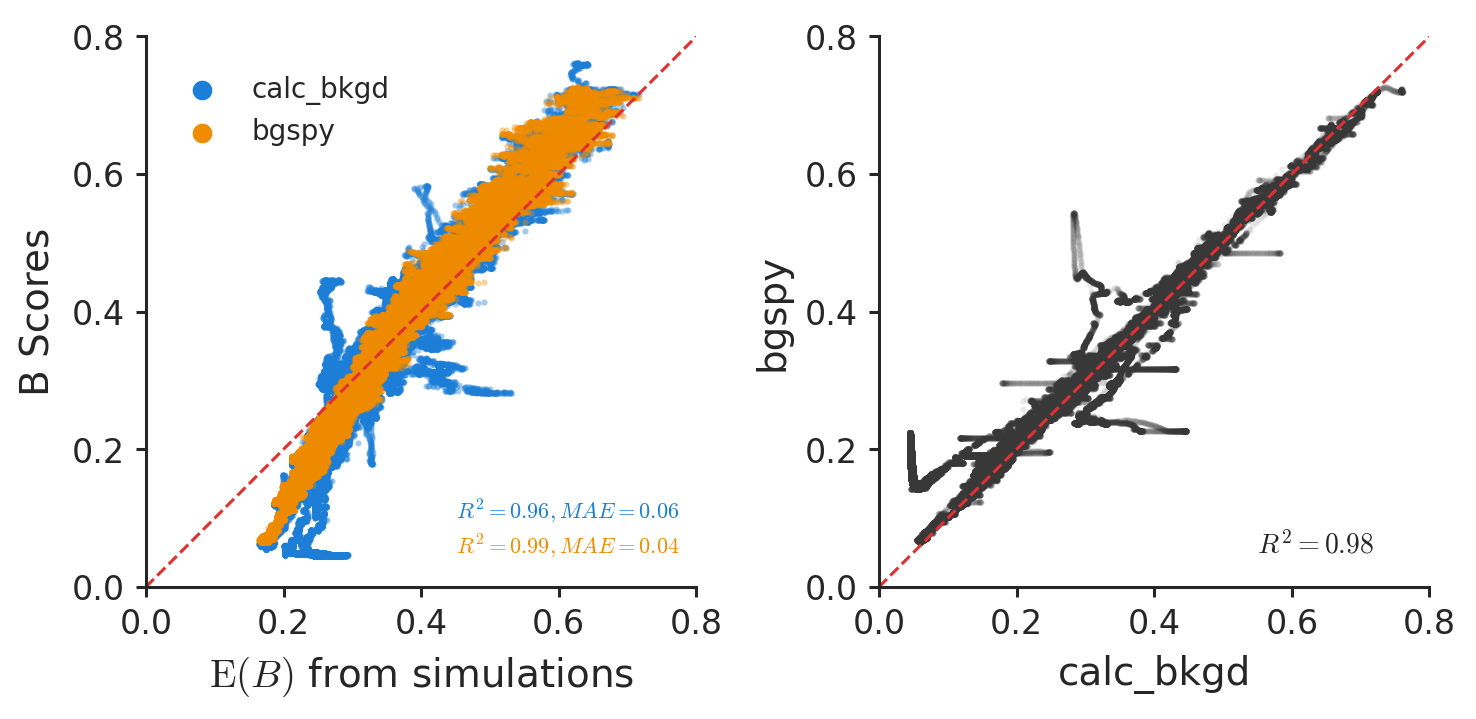

In [388]:
fig = plt.figure()

fig, ax = plt.subplots(ncols = 2)
fig.set_size_inches(*fig_sizes['two', 'one'])
x = bmean
y = np.exp(binterpols['chr10'][(1e-8, 1e-2)](midpoint(pos)))
bkgd_y = bkgd[s/2]['chr10'][1]
bkgd_func = interpolate.interp1d(bkgd[s/2]['chr10'][0], bkgd_y, fill_value=(bkgd_y[0], bkgd_y[-1]), bounds_error=False, kind='quadratic')
z = bkgd_func(midpoint(pos))

def corr(x, y, digits=2):
    return np.round(np.corrcoef(x, y)[0, 1], digits)

mae = lambda x, y: np.round(MAE(x, y), 2)

sc0 = ax[0].scatter(x, z, s=5, alpha=0.4, label='calc_bkgd', linewidth=0)
sc1 = ax[0].scatter(x, y, s=5, alpha=0.4, label='bgspy', linewidth=0)
ax[0].text(0.45, 0.1, f"$R^2 = {corr(x, z)}, MAE = {mae(x, z)}$", c=sc0.get_facecolors()[0], alpha=1, size=8)
ax[0].text(0.45, 0.05, f"$R^2 = {corr(x, y)}, MAE = {mae(x, y)}$", c=sc1.get_facecolors()[0], alpha=1, size=8)
ax[0].axline((0.1, 0.1), slope=1, c='#e03131', linestyle='dashed')
ax[0].set_xlabel("$\mathrm{E}(B)$ from simulations")
ax[0].set_ylabel("B Scores")
ax[0].set_aspect('equal', 'box')
ax[0].set_yticks(np.linspace(0, 0.8, 5))
ax[0].set_xlim((0, 0.8))
ax[0].set_ylim((0, 0.8))
leg = ax[0].legend(loc=(-0.05, 0.7))
for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh.set_sizes([50] * len(lh.get_sizes()))

#ax[1].scatter(z, y, s=4, c=(x-z)/x, cmap='brg')
ax[1].scatter(z, y, s=5, c='0.22', alpha=0.1, linewidth=0)
ax[1].text(0.55, 0.05, f"$R^2 = {np.round(np.corrcoef(z, y)[0, 1], 2)}$")
ax[1].axline((0, 0), slope=1, c='#e03131', linestyle='dashed')
ax[1].set_xlabel("calc_bkgd")
ax[1].set_ylabel("bgspy")
ax[1].set_yticks(np.linspace(0, 0.8, 5))
ax[1].set_xlim((0, 0.8))
ax[1].set_ylim((0, 0.8))
ax[1].set_aspect('equal', 'box')
plt.tight_layout()

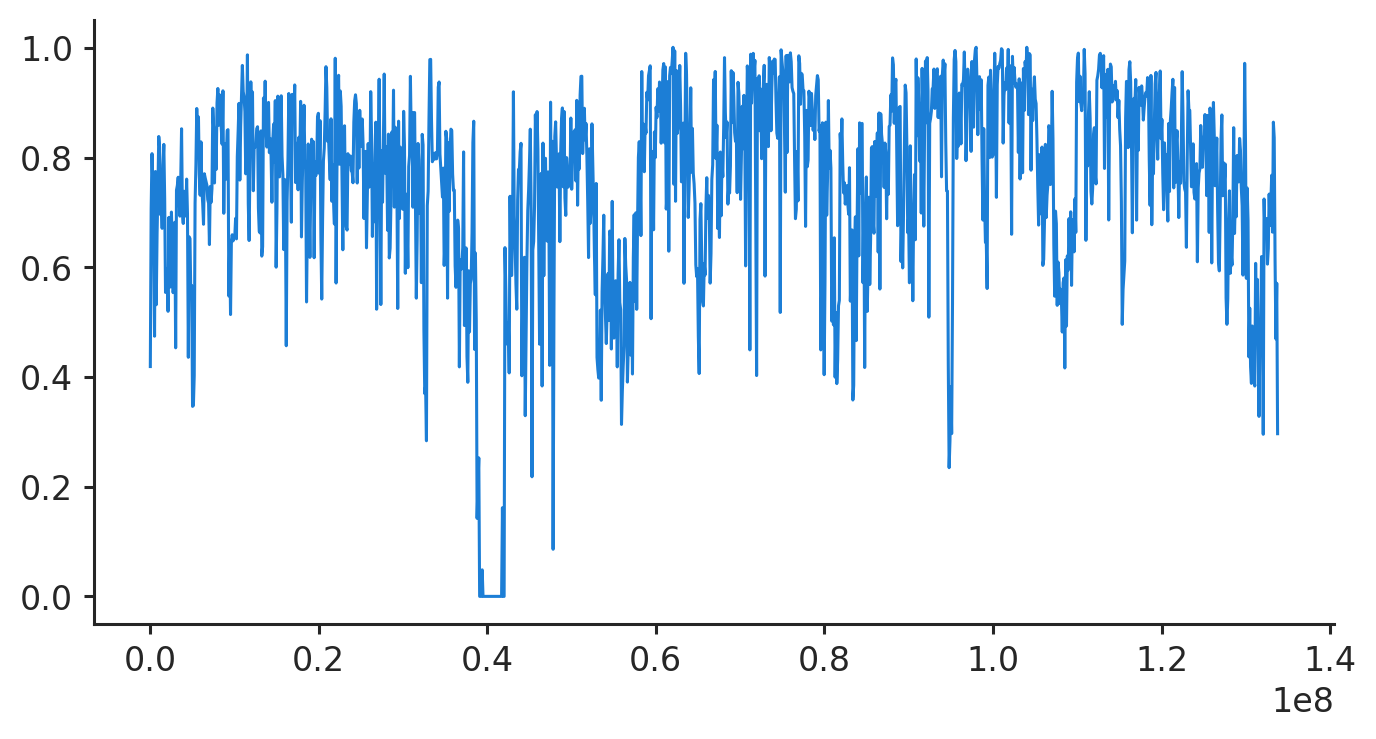

In [405]:
plt.plot(midpoint(coverage.bin_edges), coverage.statistic/100_000)

Text(0, 0.5, 'B')

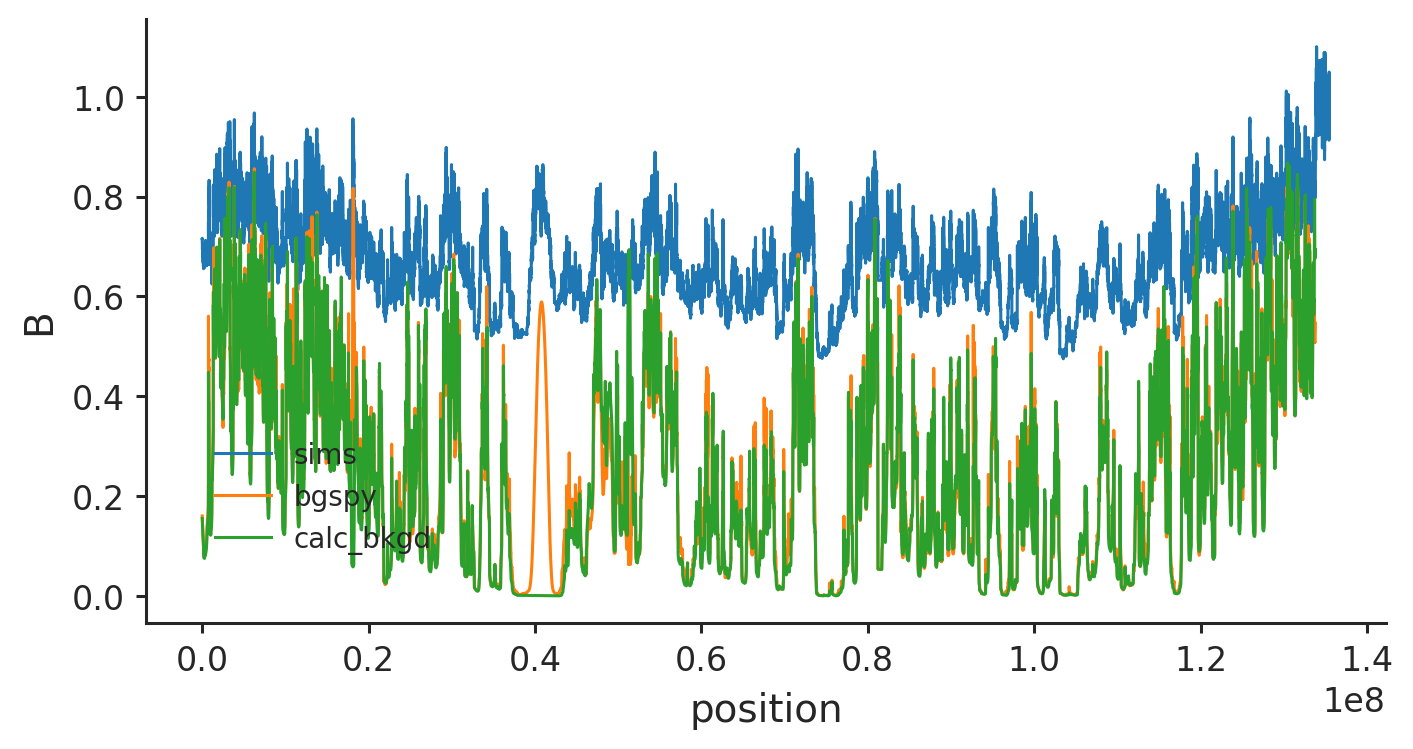

In [18]:
s, mu = 2e-3, 1e-8
pos, b = sims[(('s', s), ('mu', mu))]

fig, ax = plt.subplots()
ax.plot(midpoint(pos), b.mean(axis=1), label="sims")
bgspy_b = m.BScores.B['chr10'][:, arg_nearest(mu, m.w), arg_nearest(s, m.t), 0]
ax.plot(m.BScores.pos['chr10'], np.exp(bgspy_b), label="bgspy")
ax.plot(bkgd[s/2]['chr10'][0], bkgd[s/2]['chr10'][1], label="calc_bkgd")
ax.legend(loc='lower left')
#ax.axvline(0.375e8, c='red')
#ax.axvline(0.43e8, c='red')

ax.set_xlabel('position')
ax.set_ylabel('B')